## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shap
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve
random.seed(123)

## Loading data

In [2]:
# Loading data
df = pd.read_csv('RJ/dataset_ML_RJ.csv')
df_tplot = df['tplot']
df_cases = df['CASES_100K']
df = df.drop(columns = ['EPI_YEAR','tplot','CASES_100K'])
df['label_2'] = 0 # for most of values, no epidemic yet
df.loc[df['label'] == 'Epi','label_2'] = 1 # epidemic
df.loc[df['label'] == 'High','label_2'] = 1 # epidemic as well
df = df.drop(columns = ['label'])

## Train-test split

In [3]:
df

,EPI_WEEK,rh_max_lag,rh_min_lag,t_min_lag,t_max_lag,LAMBDA_lag,p_total_lag,label_2
0,21,96.098571,52.421429,22.462857,28.197143,0.741729,16.69,1
1,22,91.382857,64.857143,22.712857,27.888571,0.794619,12.53,0
2,23,92.267143,65.100000,22.612857,27.280000,0.956893,6.55,0
3,24,95.918571,65.035714,22.734286,27.544286,1.026744,0.84,0
4,25,93.811429,72.357143,22.038571,27.764286,1.018160,9.93,0
...,...,...,...,...,...,...,...,...
496,47,94.151429,62.652857,18.815714,27.330000,0.240050,13.33,0
497,48,90.722857,66.240000,19.970000,25.234286,0.516667,5.45,0
498,49,93.990000,60.482857,20.037143,27.360000,0.718667,0.86,0
499,50,96.062857,57.930000,19.927143,26.128571,0.444444,22.04,0


In [4]:
df['label_2'].value_counts()

0    490
1     11
Name: label_2, dtype: int64

In [5]:
X = df.iloc[:,0:7]
y = df.iloc[:,7]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.6, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)

In [6]:
print('Train: ', y_train.shape)
print('Test: ', y_test.shape)
print('Validation: ', y_val.shape)

Train:  (200,)
Test:  (150,)
Validation:  (151,)


## Doing hyperparameter tuning for XGBoost Classifier

In [7]:
hyperparameter_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [ 0.001, 0.005,0.01, 0.02, 0.05, 0.1],
    'min_child_weight': [1, 2, 5, 10, 50, 100, 150, 200]
    }

clx = XGBClassifier(random_state = 0, nthread = 8)
grid = GridSearchCV(clx, hyperparameter_grid, scoring="roc_auc", cv = 3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=8,
                                     num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_child_weight': [1, 2, 5, 10, 50, 100, 150, 200],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700]},
             scoring='roc_auc')

In [8]:
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.8941336441336442 with param: {'learning_rate': 0.001, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200}


### Tuning the threshold

In [9]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)[:,1]

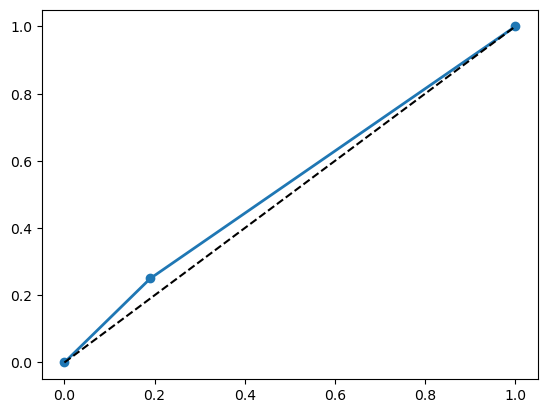

In [10]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba, pos_label = 1)
plt.plot(fpr, tpr, '-o', linewidth=2)
plt.plot([0,1], [0,1], 'k--' )

In [22]:
print(fpr)
print(tpr)
print(thresholds)

[0.         0.         0.02797203 0.02797203 0.03496503 0.04895105
 0.05594406 0.05594406 0.06993007 0.08391608 0.0979021  0.12587413
 0.13986014 0.15384615 0.15384615 0.17482517 0.2027972  0.22377622
 0.22377622 0.27272727 0.28671329 0.3006993  0.31468531 0.34265734
 0.38461538 0.41258741 0.45454545 0.46853147 0.47552448 0.48951049
 0.58041958 0.66433566 0.67832168 0.82517483 0.83216783 1.        ]
[0.    0.125 0.125 0.25  0.25  0.25  0.25  0.5   0.5   0.5   0.5   0.5
 0.5   0.5   0.75  0.75  0.75  0.75  0.875 0.875 1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
[1.5260124  0.5260124  0.30551976 0.25806797 0.24417771 0.23967382
 0.2293815  0.20152026 0.16596533 0.15355355 0.15332751 0.11664899
 0.11344367 0.09879366 0.09608562 0.07795747 0.07473946 0.07185106
 0.06939939 0.04912441 0.04722025 0.04409717 0.03797788 0.03539315
 0.02416705 0.01841887 0.0172501  0.01708863 0.01708385 0.01638938
 0.01559799 0.01479868 0.01380732 0.01309854 0.

In [23]:
thr_opt = thresholds[20]

### Setting threshold and evaluating on test

In [24]:
y_test_pred = grid.predict(X_test)
y_test_proba = grid.predict_proba(X_test)[:,1]
y_test_final = y_test_proba.copy()
y_test_final[y_test_proba >= thr_opt] = 1
y_test_final[y_test_proba < thr_opt] = 0
print(confusion_matrix(y_test, y_test_final))
print('Test Metrics')
print('False Positive Rate: ', 34/(34 + 104))
print('True Positive Rate: ', 12/(12 + 0))

[[105  37]
 [  0   8]]
Test Metrics
False Positive Rate:  0.2463768115942029
True Positive Rate:  1.0


In [25]:
y_train_pred = grid.predict(X_train)
y_train_proba = grid.predict_proba(X_train)[:,1]
y_train_final = y_train_proba.copy()
y_train_final[y_train_proba >= thr_opt] = 1
y_train_final[y_train_proba < thr_opt] = 0
print(confusion_matrix(y_train, y_train_final))
print('Train Metrics')
print('False Positive Rate: ', 18/(18 + 166))
print('True Positive Rate: ', 16/(16))

[[148  42]
 [  0  10]]
Train Metrics
False Positive Rate:  0.09782608695652174
True Positive Rate:  1.0


In [26]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)[:,1]
y_val_final = y_val_proba.copy()
y_val_final[y_val_proba >= thr_opt] = 1
y_val_final[y_val_proba < thr_opt] = 0
print(confusion_matrix(y_val, y_val_final))
print('Validation Metrics')
print('False Positive Rate: ', 18/(18 + 120))
print('True Positive Rate: ', 12/(12 + 0))

[[102  41]
 [  0   8]]
Validation Metrics
False Positive Rate:  0.13043478260869565
True Positive Rate:  1.0


### Embedded Feature Importance 

Text(0.5, 0, 'Feature Importance')

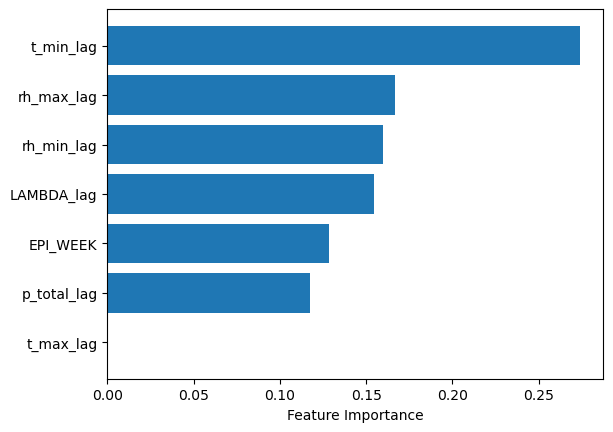

In [27]:
sorted_params = grid.best_estimator_.feature_importances_.argsort()
plt.barh(df.columns[sorted_params], grid.best_estimator_.feature_importances_[sorted_params])
plt.xlabel('Feature Importance')

### SHAP Values

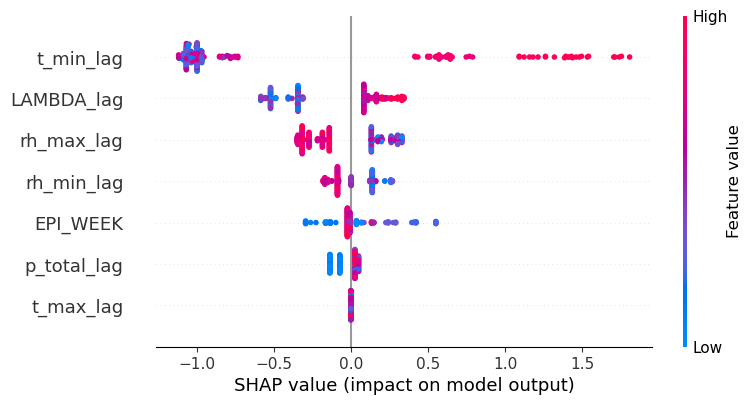

In [28]:
explainer = shap.Explainer(grid.best_estimator_)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

## Visualizing predictions - where do we fail?

In [29]:
y_pred_proba = grid.predict_proba(X)[:,1]
y_pred_final = y_pred_proba.copy()
y_pred_final[y_pred_proba >= thr_opt] = 1
y_pred_final[y_pred_proba < thr_opt] = 0

In [30]:
confusion_matrix(y, y_pred_final)

array([[355, 120],
       [  0,  26]], dtype=int64)

In [31]:
print('True positive rate: ', 40/(40 + 0))
print('False positive rate: ', 70/(70 + 390))

True positive rate:  1.0
False positive rate:  0.15217391304347827


### False negatives, which is what worries us the most

In [32]:
fn = ((y == 1) & (y_pred_final == 0))
sem_fn = X[fn]

In [33]:
sem_fn

,EPI_WEEK,rh_max_lag,rh_min_lag,t_min_lag,t_max_lag,LAMBDA_lag,p_total_lag


### False positives

In [34]:
fp = ((y == 0) & (y_pred_final == 1))
sem_fp = X[fp]

In [35]:
sem_fp['EPI_WEEK'].value_counts()

8     8
9     8
10    7
11    7
12    7
19    6
14    6
17    6
20    5
21    5
6     5
13    5
16    5
18    5
1     4
15    4
24    3
7     3
5     3
3     2
23    2
50    2
2     2
51    2
52    1
53    1
4     1
48    1
22    1
25    1
26    1
49    1
Name: EPI_WEEK, dtype: int64

### Classifying and labeling each situation

In [36]:
fn = ((y == 1) & (y_pred_final == 0))
fp = ((y == 0) & (y_pred_final == 1))
tn = ((y == 0) & (y_pred_final == 0))
tp = ((y == 1) & (y_pred_final == 1))

In [37]:
Z = X.copy()
Z['label'] = 0

In [38]:
Z.loc[fn,'label'] = 'FN'
Z.loc[fp,'label'] = 'FP'
Z.loc[tn,'label'] = 'TN'
Z.loc[tp, 'label'] = 'TP'

In [39]:
Z['tplot'] = np.array(df_tplot)
Z['CASES_100K'] = np.array(df_cases)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


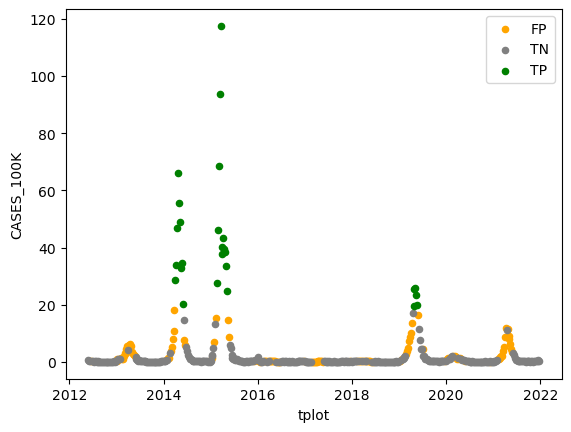

In [40]:
fig, ax = plt.subplots()

colors = {'TP':'green', 'TN':'gray', 'FP':'orange', 'FN':'red'}

grouped = Z.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='tplot', y='CASES_100K', label=key, color=colors[key])

plt.show()